In [26]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [27]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
for i in range(0, 10):
    inputImageDir = './input/' + str(i) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [28]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, num_classes):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        res = self.linear(x)
        res = self.activate(res)
        return res

In [29]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [30]:
# Parameters of training
input_size = 256
num_classes = 256
learning_rate = 0.001
batch_size = 10
num_epochs = 600

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, num_classes=num_classes).to(device)

if not os.path.exists('./models'):
    os.mkdir('./models')
torch.save(model, './models/net_untrained.pkl')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [31]:
# Step 3
model = Perceptron(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = [] 
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2526 MAE: 0.4869 Mean Error: 0.4040 STD: 0.2990
[10/600] Loss: 0.0435 MAE: 0.1545 Mean Error: 0.0921 STD: 0.1871
[20/600] Loss: 0.0309 MAE: 0.0911 Mean Error: 0.0339 STD: 0.1724
[30/600] Loss: 0.0284 MAE: 0.0779 Mean Error: 0.0211 STD: 0.1672
[40/600] Loss: 0.0266 MAE: 0.0730 Mean Error: 0.0164 STD: 0.1624
[50/600] Loss: 0.0251 MAE: 0.0709 Mean Error: 0.0149 STD: 0.1577
[60/600] Loss: 0.0237 MAE: 0.0690 Mean Error: 0.0140 STD: 0.1533
[70/600] Loss: 0.0223 MAE: 0.0673 Mean Error: 0.0135 STD: 0.1489
[80/600] Loss: 0.0211 MAE: 0.0658 Mean Error: 0.0127 STD: 0.1447
[90/600] Loss: 0.0199 MAE: 0.0641 Mean Error: 0.0124 STD: 0.1406
[100/600] Loss: 0.0188 MAE: 0.0624 Mean Error: 0.0119 STD: 0.1367
[110/600] Loss: 0.0178 MAE: 0.0608 Mean Error: 0.0117 STD: 0.1329
[120/600] Loss: 0.0168 MAE: 0.0592 Mean Error: 0.0114 STD: 0.1292
[130/600] Loss: 0.0159 MAE: 0.0576 Mean Error: 0.0111 STD: 0.1256
[140/600] Loss: 0.0150 MAE: 0.0561 Mean Error: 0.0108 STD: 0.1222
[150/600] Loss: 0.014

In [32]:
# Step 4
# Step 4a
# Export the image after training
# Before executing this block, create a folder called "output"
if not os.path.exists('./output'):
    os.mkdir('./output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models/net_trained.pkl')
output_dataset = np.zeros([10, 256])
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
#     img = img.convert("1")
    threshold = 50
    img = img.point(lambda p: p > threshold and 255)
    output_path = './output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(10, 256)


In [33]:
# Step 4b
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [34]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [35]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.96       0.97297297 0.98333333 0.96385542 0.97142857 0.96899225
 0.94805195 0.95266272 0.94897959 0.95022624]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
# TODO: Step 4c: Graph Fh as a function of Ffa for each exemplar in the input dataset

In [37]:
# Step 5
def gaussian_noise(img, mean, sigma):
    # Generate gauss noise
    noise = np.random.normal(mean, sigma, img.shape)
    # Add the noise to image
    gaussian_out = img + noise
    # Make the value between 0 and 1
    gaussian_out = np.clip(gaussian_out, 0, 1)
    return gaussian_out

gaussian_dataset = np.zeros([9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
if not os.path.exists('./input_noise/'):
    os.mkdir('./input_noise/')
for j in range(9):
    if not os.path.exists('./input_noise/' + str(std[j])):
        os.mkdir('./input_noise/' + str(std[j]))
    for i in range(10):
        inputImage = dataSet[i]
        gaussian_data = gaussian_noise(inputImage, 0, std[j])
        img = gaussian_data.reshape(16, 16)*255
        img = Image.fromarray(np.uint8(img))
        img.convert("1")
        inputImageDir = './input_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(inputImageDir)
        gaussian_dataset[j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)


Fh_noise_array = np.zeros([9, 10])
Ffa_noise_array = np.zeros([9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise/'):
    os.mkdir('./output_noise/')
for j in range(9):
    train_noise_dataset = DigitDataset(dataset = gaussian_dataset[j], label_list = dataSet)
    train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
    print('Training dataset with noise standard deviation ' + str(std[j]))
#     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
    model_noise = Perceptron(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)
    output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
    torch.save(model_noise, './models/net_trained_' + str(std[j]) + '.pkl')
    model_noise = torch.load('./models/net_trained_' + str(std[j]) + '.pkl')
#     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
    print('------------------------------------')
    output_noise = model_noise(torch.from_numpy(dataSet).float())
    output_noise_np = output_noise.detach().numpy()     # Get the output
#     print(output_noise_np)
    output_noise_dataset = np.zeros([10, 256])
#     Make the output only has 0 or 1
    
    if not os.path.exists('./output_noise/' + str(std[j])):
        os.mkdir('./output_noise/' + str(std[j]))
    for i in range(10):
        output_noise_img = output_noise_np[i].reshape(16, 16)*255
        img = Image.fromarray(np.uint8(output_noise_img))
#         img = img.convert("1")
        threshold = 50
        img = img.point(lambda p: p > threshold and 255)
        output_path = './output_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(output_path)
        data = img.getdata()
        array = np.array(data)/255
        output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    Fh = calculateFh(dataSet, output_noise_dataset)
    Ffa = calculateFfa(dataSet, output_noise_dataset)
    Fh_noise_array[j] = Fh
    Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2691 MAE: 0.5033 Mean Error: 0.4197 STD: 0.3049
[10/600] Loss: 0.0443 MAE: 0.1594 Mean Error: 0.0974 STD: 0.1867
[20/600] Loss: 0.0306 MAE: 0.0920 Mean Error: 0.0356 STD: 0.1712
[30/600] Loss: 0.0280 MAE: 0.0777 Mean Error: 0.0201 STD: 0.1660
[40/600] Loss: 0.0262 MAE: 0.0735 Mean Error: 0.0175 STD: 0.1610
[50/600] Loss: 0.0247 MAE: 0.0709 Mean Error: 0.0153 STD: 0.1566
[60/600] Loss: 0.0234 MAE: 0.0688 Mean Error: 0.0140 STD: 0.1522
[70/600] Loss: 0.0221 MAE: 0.0673 Mean Error: 0.0138 STD: 0.1480
[80/600] Loss: 0.0209 MAE: 0.0657 Mean Error: 0.0131 STD: 0.1438
[90/600] Loss: 0.0197 MAE: 0.0641 Mean Error: 0.0126 STD: 0.1398
[100/600] Loss: 0.0186 MAE: 0.0625 Mean Error: 0.0123 STD: 0.1359
[110/600] Loss: 0.0176 MAE: 0.0609 Mean Error: 0.0119 STD: 0.1322
[120/600] Loss: 0.0166 MAE: 0.0593 Mean Error: 0.0116 STD: 0.1285
[130/600] Loss: 0.0157 MAE: 0.0577 Mean Error: 0.0113 STD: 0.1250
[140/600] Loss: 0.0149 MAE: 0.0562

[40/600] Loss: 0.0264 MAE: 0.0729 Mean Error: 0.0170 STD: 0.1616
[50/600] Loss: 0.0249 MAE: 0.0707 Mean Error: 0.0144 STD: 0.1571
[60/600] Loss: 0.0235 MAE: 0.0691 Mean Error: 0.0134 STD: 0.1527
[70/600] Loss: 0.0222 MAE: 0.0674 Mean Error: 0.0130 STD: 0.1484
[80/600] Loss: 0.0210 MAE: 0.0658 Mean Error: 0.0125 STD: 0.1443
[90/600] Loss: 0.0198 MAE: 0.0642 Mean Error: 0.0123 STD: 0.1403
[100/600] Loss: 0.0188 MAE: 0.0625 Mean Error: 0.0120 STD: 0.1365
[110/600] Loss: 0.0178 MAE: 0.0609 Mean Error: 0.0117 STD: 0.1328
[120/600] Loss: 0.0168 MAE: 0.0593 Mean Error: 0.0113 STD: 0.1292
[130/600] Loss: 0.0159 MAE: 0.0577 Mean Error: 0.0111 STD: 0.1257
[140/600] Loss: 0.0151 MAE: 0.0562 Mean Error: 0.0109 STD: 0.1224
[150/600] Loss: 0.0143 MAE: 0.0548 Mean Error: 0.0106 STD: 0.1191
[160/600] Loss: 0.0136 MAE: 0.0533 Mean Error: 0.0104 STD: 0.1160
[170/600] Loss: 0.0129 MAE: 0.0520 Mean Error: 0.0101 STD: 0.1130
[180/600] Loss: 0.0122 MAE: 0.0506 Mean Error: 0.0099 STD: 0.1101
[190/600] Loss: 

[40/600] Loss: 0.0264 MAE: 0.0724 Mean Error: 0.0168 STD: 0.1617
[50/600] Loss: 0.0250 MAE: 0.0703 Mean Error: 0.0152 STD: 0.1574
[60/600] Loss: 0.0236 MAE: 0.0684 Mean Error: 0.0143 STD: 0.1531
[70/600] Loss: 0.0224 MAE: 0.0667 Mean Error: 0.0137 STD: 0.1489
[80/600] Loss: 0.0212 MAE: 0.0654 Mean Error: 0.0131 STD: 0.1449
[90/600] Loss: 0.0201 MAE: 0.0640 Mean Error: 0.0126 STD: 0.1411
[100/600] Loss: 0.0190 MAE: 0.0625 Mean Error: 0.0121 STD: 0.1373
[110/600] Loss: 0.0180 MAE: 0.0609 Mean Error: 0.0118 STD: 0.1337
[120/600] Loss: 0.0171 MAE: 0.0594 Mean Error: 0.0115 STD: 0.1302
[130/600] Loss: 0.0162 MAE: 0.0579 Mean Error: 0.0112 STD: 0.1267
[140/600] Loss: 0.0153 MAE: 0.0564 Mean Error: 0.0109 STD: 0.1234
[150/600] Loss: 0.0146 MAE: 0.0550 Mean Error: 0.0106 STD: 0.1202
[160/600] Loss: 0.0138 MAE: 0.0536 Mean Error: 0.0104 STD: 0.1171
[170/600] Loss: 0.0131 MAE: 0.0523 Mean Error: 0.0101 STD: 0.1141
[180/600] Loss: 0.0125 MAE: 0.0510 Mean Error: 0.0099 STD: 0.1112
[190/600] Loss: 

[50/600] Loss: 0.0253 MAE: 0.0719 Mean Error: 0.0152 STD: 0.1584
[60/600] Loss: 0.0239 MAE: 0.0699 Mean Error: 0.0138 STD: 0.1540
[70/600] Loss: 0.0226 MAE: 0.0683 Mean Error: 0.0133 STD: 0.1497
[80/600] Loss: 0.0213 MAE: 0.0667 Mean Error: 0.0127 STD: 0.1456
[90/600] Loss: 0.0202 MAE: 0.0650 Mean Error: 0.0125 STD: 0.1415
[100/600] Loss: 0.0191 MAE: 0.0632 Mean Error: 0.0121 STD: 0.1376
[110/600] Loss: 0.0180 MAE: 0.0616 Mean Error: 0.0119 STD: 0.1338
[120/600] Loss: 0.0170 MAE: 0.0600 Mean Error: 0.0116 STD: 0.1300
[130/600] Loss: 0.0161 MAE: 0.0584 Mean Error: 0.0113 STD: 0.1265
[140/600] Loss: 0.0152 MAE: 0.0568 Mean Error: 0.0111 STD: 0.1230
[150/600] Loss: 0.0144 MAE: 0.0553 Mean Error: 0.0108 STD: 0.1196
[160/600] Loss: 0.0137 MAE: 0.0539 Mean Error: 0.0106 STD: 0.1164
[170/600] Loss: 0.0129 MAE: 0.0525 Mean Error: 0.0103 STD: 0.1133
[180/600] Loss: 0.0123 MAE: 0.0511 Mean Error: 0.0101 STD: 0.1104
[190/600] Loss: 0.0116 MAE: 0.0498 Mean Error: 0.0098 STD: 0.1075
[200/600] Loss:

[90/600] Loss: 0.0191 MAE: 0.0640 Mean Error: 0.0132 STD: 0.1378
[100/600] Loss: 0.0180 MAE: 0.0622 Mean Error: 0.0128 STD: 0.1334
[110/600] Loss: 0.0168 MAE: 0.0604 Mean Error: 0.0124 STD: 0.1292
[120/600] Loss: 0.0158 MAE: 0.0586 Mean Error: 0.0121 STD: 0.1251
[130/600] Loss: 0.0148 MAE: 0.0569 Mean Error: 0.0117 STD: 0.1212
[140/600] Loss: 0.0139 MAE: 0.0552 Mean Error: 0.0114 STD: 0.1174
[150/600] Loss: 0.0131 MAE: 0.0535 Mean Error: 0.0111 STD: 0.1138
[160/600] Loss: 0.0123 MAE: 0.0520 Mean Error: 0.0108 STD: 0.1103
[170/600] Loss: 0.0116 MAE: 0.0505 Mean Error: 0.0105 STD: 0.1070
[180/600] Loss: 0.0109 MAE: 0.0490 Mean Error: 0.0103 STD: 0.1038
[190/600] Loss: 0.0103 MAE: 0.0476 Mean Error: 0.0100 STD: 0.1008
[200/600] Loss: 0.0097 MAE: 0.0463 Mean Error: 0.0097 STD: 0.0979
[210/600] Loss: 0.0091 MAE: 0.0451 Mean Error: 0.0095 STD: 0.0952
[220/600] Loss: 0.0086 MAE: 0.0438 Mean Error: 0.0093 STD: 0.0925
[230/600] Loss: 0.0082 MAE: 0.0427 Mean Error: 0.0091 STD: 0.0900
[240/600] L

In [38]:
# TODO: Step 6: Display Data from your Tests in Step 5

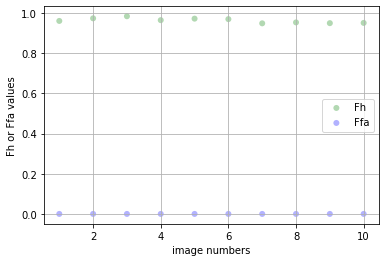

In [39]:
# Display the scatter plot of fh and ffa NO NOISE!!!
import numpy as np
import matplotlib.pyplot as plt

std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()


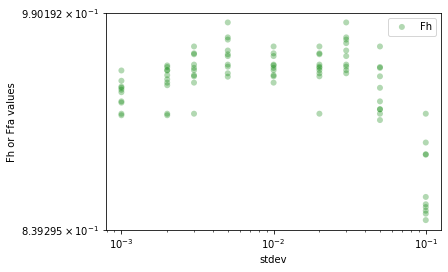

In [49]:
# display the scatter plot of fh ffa with noise. 
fig, ax = plt.subplots()
ax.scatter(std_plot, Fh_noise_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter(std_plot, Ffa_noise_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
plt.xscale("log")
plt.yscale("symlog")
ax.legend()
plt.show()

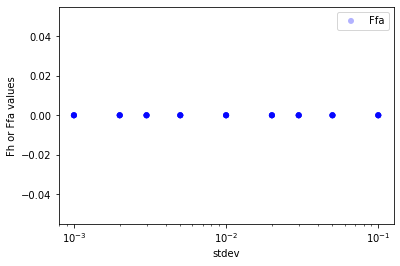

In [41]:
# display the scatter plot of fh ffa with noise. 
fig, ax = plt.subplots()
# ax.scatter(std_plot, Fh_noise_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(std_plot, Ffa_noise_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
plt.xscale("log")
# plt.yscale("symlog")
ax.legend()
plt.show()

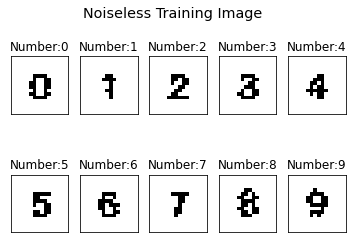

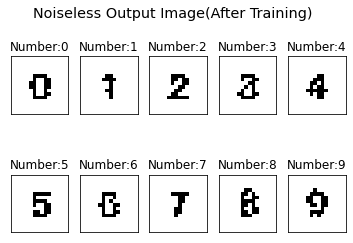

In [42]:
# display the image

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


N=2
M=5
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Noiseless Training Image", fontsize="x-large")
for i in range(10):#有10张图片
    path='./input/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

# Output Image display (Noiseless)

N=2
M=5
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Noiseless Output Image(After Training)", fontsize="x-large")
for i in range(10):#有10张图片
    path='./output/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

In [43]:
#  print Fh and Ffa as a table without noise
#!/usr/bin/python
#**coding:utf-8**
import sys
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Image(Number)','Fh','Ffa']

for i in range(10):
    table.add_row([i,Fh_array[i],round(Ffa_array[i],5)])
print(table)

+---------------+--------------------+-----+
| Image(Number) |         Fh         | Ffa |
+---------------+--------------------+-----+
|       0       |        0.96        | 0.0 |
|       1       | 0.972972972972973  | 0.0 |
|       2       | 0.9833333333333333 | 0.0 |
|       3       | 0.963855421686747  | 0.0 |
|       4       | 0.9714285714285714 | 0.0 |
|       5       | 0.9689922480620154 | 0.0 |
|       6       | 0.948051948051948  | 0.0 |
|       7       | 0.9526627218934911 | 0.0 |
|       8       | 0.9489795918367347 | 0.0 |
|       9       | 0.9502262443438914 | 0.0 |
+---------------+--------------------+-----+


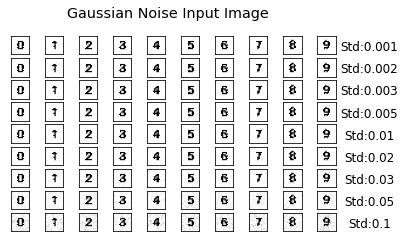

In [44]:
# Display the Input Image with Noise 
import matplotlib.pyplot as plt
import numpy as np

std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=500
M=500
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./input_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = ("Std:"+str(j))
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

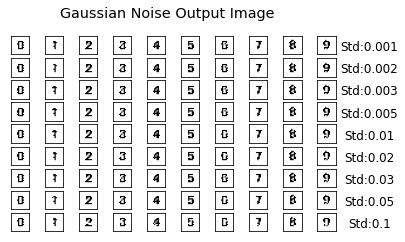

In [54]:
# Display the Onput Image with Noise 
import matplotlib.pyplot as plt
import numpy as np
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=100
M=100
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Output Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./output_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = ("Std:"+str(j))
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

In [46]:
# displaying the fh and ffa as a table with NOISE
'''
NOTE: the table will be very big. For better displaying, please run the code in Pycharm.

'''


from prettytable import PrettyTable
table = PrettyTable()
[0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
table.field_names = ['Number','Stdev=0.001','Stdev=0.002','Stdev=0.003','Stdev=0.005','Stdev=0.01','Stdev=0.02','Stdev=0.03','Stdev=0.05','Stdev=0.1']

image_index = 0
for j in range(10):
    for i in range(1):
        table.add_row([image_index,
                   'fh:'+str(Fh_noise_array[i][j])+' ffa:'+str(round(Ffa_noise_array[i][j],4)),
                  'fh:'+str(Fh_noise_array[i+1][j])+' ffa:'+str(round(Ffa_noise_array[i+1][j],4)),
                   'fh:'+str(Fh_noise_array[i+2][j])+' ffa:'+str(round(Ffa_noise_array[i+2][j],4)),
                   'fh:'+str(Fh_noise_array[i+3][j])+' ffa:'+str(round(Ffa_noise_array[i+3][j],4)),
                   'fh:'+str(Fh_noise_array[i+4][j])+' ffa:'+str(round(Ffa_noise_array[i+4][j],4)),
                   'fh:'+str(Fh_noise_array[i+5][j])+' ffa:'+str(round(Ffa_noise_array[i+5][j],4)),
                   'fh:'+str(Fh_noise_array[i+6][j])+' ffa:'+str(round(Ffa_noise_array[i+6][j],4)),
                   'fh:'+str(Fh_noise_array[i+7][j])+' ffa:'+str(round(Ffa_noise_array[i+7][j],4)),
                   'fh:'+str(Fh_noise_array[i+8][j])+' ffa:'+str(round(Ffa_noise_array[i+8][j],4))
                  ])
    image_index += 1
print(table)

+--------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
| Number |          Stdev=0.001          |          Stdev=0.002          |          Stdev=0.003          |          Stdev=0.005          |           Stdev=0.01          |           Stdev=0.02          |           Stdev=0.03          |           Stdev=0.05          |           Stdev=0.1           |
+--------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|   0    |        fh:0.92 ffa:0.0        |        fh:0.92 ffa:0.0        |        fh:0.92 ffa:0.0      

In [53]:
Fh_array

array([0.96      , 0.97297297, 0.98333333, 0.96385542, 0.97142857,
       0.96899225, 0.94805195, 0.95266272, 0.94897959, 0.95022624])